In [10]:
import random
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import norm, skewnorm

In [11]:
def rms(x, axis=None):
    if axis is not None:
        return np.sqrt(np.sum(x**2, axis=axis) / x.shape[axis])
    return np.sqrt(np.sum(x**2) / x.size)

In [14]:
import os

zones = ['ISONE CA', 'ME', 'RI', 'VT', 'CT', 'NH', 'SEMASS', 'WCMASS', 'NEMASSBOST']

test_z_scores_dict = dict()
test_z_scores = []

z_scores_dict = dict()
z_scores = []

relative_perfs = pd.DataFrame()
relative = []

folder = ".\\experiments\\vanilla_comp\\"
for fname in os.listdir(folder):
    if fname.endswith("relative_perfs.npy"):
        month = fname[12:15]
        relative_perfs[month] = np.load(os.path.join(folder, fname))
        relative.extend(relative_perfs[month])
    if fname.endswith("test_z_scores.npy"):
        month = fname[12:15]
        test_z_scores_dict[month] = np.load(os.path.join(folder, fname))
        test_z_scores.extend((test_z_scores_dict[month][:, :, 0][0]).tolist())
    elif fname.endswith("z_scores.npy"):
        month = fname[12:15]
        z_scores_dict[month] = np.load(os.path.join(folder, fname))
        z_scores.extend((z_scores_dict[month][:, :, 0][0]).tolist())
relative_perfs.index = ['ISONE CA', 'ME', 'RI', 'VT', 'CT', 'NH', 'SEMASS', 'WCMASS', 'NEMASSBOST']
relative_perfs = relative_perfs.T
relative_perfs = relative_perfs.loc[["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]]

In [15]:
relative_perfs["avg"] = relative_perfs.mean(axis=1)
relative_perfs

,ISONE CA,ME,RI,VT,CT,NH,SEMASS,WCMASS,NEMASSBOST,avg
Jan,12.437128,9.570205,-6.202717,6.464242,7.839720,21.447182,12.242199,6.068375,8.100620,8.662995
Feb,-5.790640,-11.501339,10.080240,1.932900,10.219792,-6.260119,4.353096,0.429722,3.396467,0.762236
Mar,24.085213,24.995224,26.281768,29.196060,22.809465,26.447247,27.650727,16.079500,15.663487,23.689855
Apr,22.662085,-17.340669,23.674974,32.251986,33.119135,27.094130,35.727053,32.313660,28.039654,24.171334
May,6.055429,7.628917,-7.016208,20.435947,-2.513361,9.351281,-0.360822,-0.706151,-11.020781,2.428250
Jun,12.994303,16.337196,21.106336,3.924574,20.699588,17.492143,11.462495,9.347923,2.527765,12.876925
Jul,25.807899,23.161130,21.194531,10.643614,30.961741,29.256298,19.079821,15.190192,10.767818,20.673672
Aug,16.568283,20.850924,17.718659,8.005167,21.547542,25.670266,15.839616,-5.972915,1.152349,13.486655
Sep,-5.529018,1.070840,7.253269,5.103601,-3.602710,-0.123591,-0.621372,-2.917112,-0.655985,-0.002453
Oct,0.773252,12.312211,-1.918996,14.097592,0.873048,13.030590,6.217933,2.556025,5.721681,5.962593


In [16]:
np.std(relative)

11.6036896948621

In [17]:
# 95\% confidence interval (not accurate, these samples are not independent). We assume that the 6 months we tested on (every other month) are representative
# of our overall performance on the 6 rounds of GEFCom2017. (maybe explain more why this is as fair of a comparison as it gets)
me = np.mean(relative), 
er = np.std(relative_perfs.avg, ddof=1) / np.sqrt(12)  # ?
print(me, 2 * er)
me - 2 * er, me + 2 * er

(11.210551042408472,) 5.296086752870554


(array([5.91446429]), array([16.5066378]))

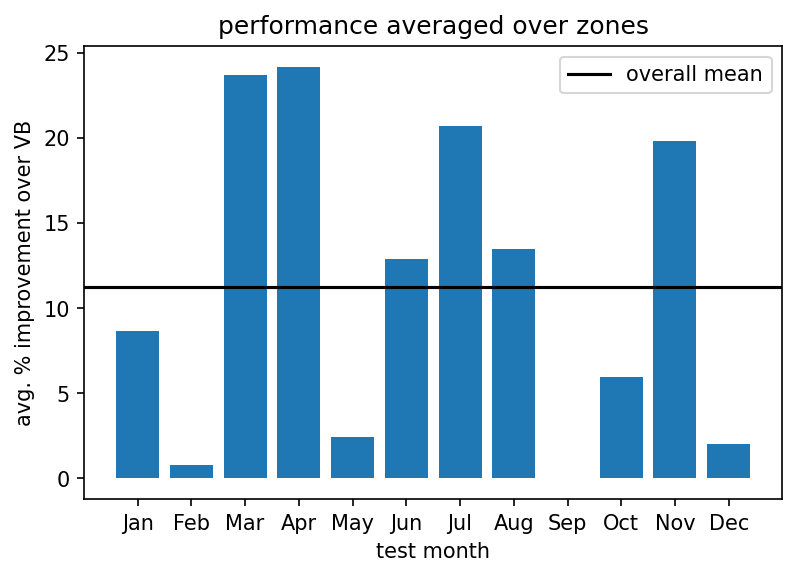

In [18]:
plt.figure(dpi=150)
plt.bar(np.arange(12), relative_perfs.avg, tick_label=relative_perfs.index)
plt.axhline(me, color="k", label="overall mean")
plt.title("performance averaged over zones")
plt.ylabel("avg. % improvement over VB")
plt.xlabel("test month")
plt.legend()

(-0.30935511487652756, 1.2199308014257895)

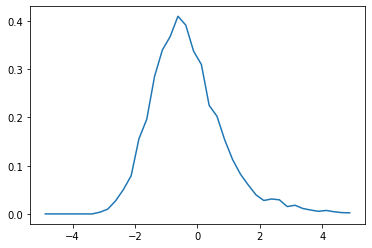

In [11]:
z_hist, bin_edges = np.histogram(test_z_scores, bins=40, range=(-5, 5), density=True)
z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.plot(z_axis, z_hist, label="Koopman test z-scores")
# plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
# plt.title(list(all_data.keys())[i])
np.mean(test_z_scores), np.mean(rms(np.array(test_z_scores)))

In [12]:
mar_z = np.array(test_z_scores_dict["Mar"])
mar_z.std(axis=1)

array([[1.21308564],
       [0.91726423],
       [1.1737755 ],
       [1.45926772],
       [1.20578041],
       [1.20769826],
       [1.19970282],
       [1.27310501],
       [1.28774317]])

(-0.02707384298888987, 0.9737972309432206)

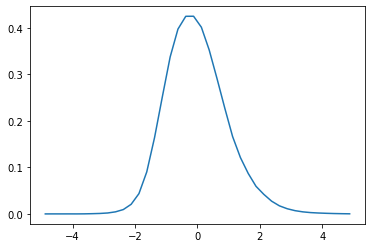

In [13]:
z_hist, bin_edges = np.histogram(z_scores, bins=40, range=(-5, 5), density=True)
z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.plot(z_axis, z_hist, label="Koopman train z-scores")
# plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
# plt.title(list(all_data.keys())[i])
np.mean(z_scores), np.std(z_scores)

In [14]:
list(np.mean(test_z_scores_dict[mo]) for mo in relative_perfs.index)

[-0.5742616549665047,
 -0.8931502503227425,
 0.15497558559142474,
 -0.3802324627280704,
 -0.2902479867490024,
 -0.11282195854511021,
 -0.48067210306814695,
 -0.610997502938538,
 -0.05055767952011566,
 -0.3121570583114605,
 -0.16144202399979662,
 0.5644286115598942]

In [6]:
relative_perfs["avg"] = relative_perfs.mean(axis=1)
relative_perfs

,ISONE CA,ME,RI,VT,CT,NH,SEMASS,WCMASS,NEMASSBOST,avg
Jan,13.592506,7.236752,-6.215116,7.746979,3.906798,21.472776,11.770540,9.247547,6.775420,8.392689
Feb,-7.188434,-9.939449,6.296061,4.654600,7.691406,-7.350878,3.687269,-2.339584,4.136036,-0.039219
Mar,23.833443,25.278269,26.111572,28.561030,23.632270,27.080959,27.842376,16.704992,14.251738,23.699628
Apr,20.477089,-18.979579,23.618312,32.365015,33.813207,27.663434,35.118771,32.875166,27.338120,23.809948
May,5.424575,1.642643,-6.786470,21.734621,-3.482819,8.421488,2.127361,-0.110955,-12.081322,1.876569
Jun,13.665448,16.210534,20.875809,5.031805,21.380714,17.575073,10.780926,9.669403,2.083607,13.030369
Jul,26.277853,23.731817,19.811630,9.921223,30.552949,29.724549,19.395234,14.566929,12.041061,20.669249
Aug,16.919618,22.449793,18.305715,10.086784,22.072362,27.786850,18.239768,-3.215009,-1.637649,14.556470
Sep,-5.316200,2.166968,5.102784,3.977093,-2.104084,0.033106,0.345824,-2.654832,0.625954,0.241846
Oct,-0.188981,12.121388,0.783305,13.842552,1.054683,9.400052,7.062053,3.816700,5.516739,5.934277
